In [168]:
# Paths
player_data_path = "/Users/aryandaga/Desktop/game_state_frame_data.parquet"
output_path = "/Users/aryandaga/Desktop/output_path.parquet"

In [169]:
#Libraries
import pandas as pd
import matplotlib.path as pth

In [170]:
class ProcessGameState:
    def __init__(self, player_data_path):
        self.data = pd.read_parquet(player_data_path, engine='pyarrow')
        
    def in_boundary(self, boundary_points, point, z_bounds):
        boundary = pth.Path(boundary_points)
        x, y, z = point
        z_min, z_max = z_bounds
        return (boundary.contains_point([x,y])) and (z_min <= z <= z_max)
        
    def filter_by(self, trait, trait_value, output_path):
        filtered_row = []
        for _,row in self.data.iterrows():
            if row[trait] == trait_value:
                filtered_row.append(row)
        df = pd.DataFrame(filtered_row)
        df.to_parquet(output_path, engine='pyarrow')
                
    def extract_weapon_classes(self, row):
        weapon_classes = []
        if row['inventory'] is None:
            return weapon_classes
        else:
            for item in row['inventory']:
                weapon_classes.append(item.get('weapon_class'))
        return weapon_classes

In [171]:
# a)  Is entering via the light blue boundary a common strategy used by Team2 on T (terrorist) side?
p1 = ProcessGameState(player_data_path)
z_bounds = (285, 421) # z coordinates for 
boundary_points = [[-1735, 250], [-2024, 398], [-2806, 742], [-2472, 1233], [-1565, 580]] #enter x, y coordinates for boundry
p1.filter_by('side', 'T', output_path) # filters list based on side (T or CT)
p2 = ProcessGameState(output_path) 
p2.filter_by('team', 'Team2', output_path) # filters list based on team (Team1 or Team2)
p3 = ProcessGameState(output_path) 

p3.data = p3.data.sort_values('round_num')

# For loop that goes through filtered list and counts if team2 enters boundary in different matches
true_rounds = [] #Contains rounds where the boundary was entered
all_rounds = p3.data['round_num'].unique() # contains rounds in sorted list
for _,row in p3.data.iterrows():
    if not (row['round_num'] in true_rounds) and p3.in_boundary(boundary_points, (row['x'], row['y'], row['z']), z_bounds):
        true_rounds.append(row['round_num'])
print(len(true_rounds), len(all_rounds)) 
# Output is: (1, 15)

'''
Answer: We can say from the above output (1,15) that entering through the light blue boundary isn't a common
strategy used by Team2 on T side as team2 entered the blue area only 1 round in 15 rounds. 
'''


1 15


"\nAnswer: We can say from the above output (1,15) that entering through the light blue boundary isn't a common\nstrategy used by Team2 on T side as team2 entered the blue area only 1 round in 15 rounds. \n"

In [172]:
# b. What is the average timer that Team2 on T (terrorist) side enters “BombsiteB” with least 2 rifles or SMGs?
p1 = ProcessGameState(player_data_path)
p1.filter_by('side', 'T', output_path) # filters list based on side (T or CT)
p2 = ProcessGameState(output_path) 
p2.filter_by('team', 'Team2', output_path) # filters list based on team (Team1 or Team2)
p3 = ProcessGameState(output_path) 

p3.data = p3.data.sort_values('round_num')

count = 0
gun_list = []
processed_player = []
processed_rounds = []
all_rounds = p3.data['round_num'].unique()
for _, row in p3.data.iterrows():
    if not (row['round_num'] in processed_rounds):
        if not row['player'] in processed_player:
            processed_player.append(row['player'])
            gun_list.extend(p3.extract_weapon_classes(row))
        if len(processed_player) == 5:
            print(gun_list)
            if gun_list.count('Rifle') + gun_list.count('SMGs') >= 2:
                count = count + 1
            processed_player = []
            gun_list = []
            processed_rounds.append(row['round_num'])
            
print(count, len(all_rounds))
# Output for the above is (10, 15)

'''
From the above output we can say that the average time that Team2 on T side enters BombsideB with atleast 2 rifles
or SMGS is 10/15 which is majority of the time or 66.66% of the times
'''

['Pistols', 'Pistols', 'Pistols', 'Pistols', 'Pistols']
['Grenade', 'Pistols', 'Rifle', 'Grenade', 'Grenade', 'Pistols', 'Rifle', 'Pistols', 'Rifle', 'Grenade', 'Grenade', 'Grenade', 'Pistols', 'Rifle', 'Grenade', 'Rifle', 'Grenade', 'Pistols']
['Grenade', 'Pistols', 'Rifle', 'Grenade', 'Pistols', 'Grenade', 'Rifle', 'Grenade', 'Grenade', 'Grenade', 'Grenade', 'Pistols', 'Rifle', 'Grenade', 'Grenade', 'Grenade', 'Grenade', 'Pistols', 'Rifle']
['Grenade', 'Grenade', 'Rifle', 'Grenade', 'Pistols', 'Pistols', 'Rifle', 'Grenade', 'Pistols', 'Rifle', 'Grenade']
['Pistols', 'Pistols', 'Pistols', 'Pistols']
['Pistols', 'Rifle', 'Grenade', 'Pistols', 'Rifle', 'Grenade', 'Rifle', 'Pistols', 'Grenade', 'Pistols', 'Rifle']
['Rifle', 'Pistols', 'Pistols', 'Rifle', 'Pistols']
['Pistols', 'Rifle', 'Rifle', 'Grenade', 'Pistols']
['Grenade', 'Grenade', 'Pistols', 'Rifle', 'Pistols', 'Rifle', 'Grenade', 'Pistols', 'Rifle']
['Pistols', 'Pistols', 'Grenade']
['Pistols', 'Rifle', 'Grenade', 'Grenade', 'Pi

'\nFrom the above output we can say that the average time that Team2 on T side enters BombsideB with atleast 2 rifles\nor SMGS is 10/15 which is majority of the time or 66.66% of the times\n'

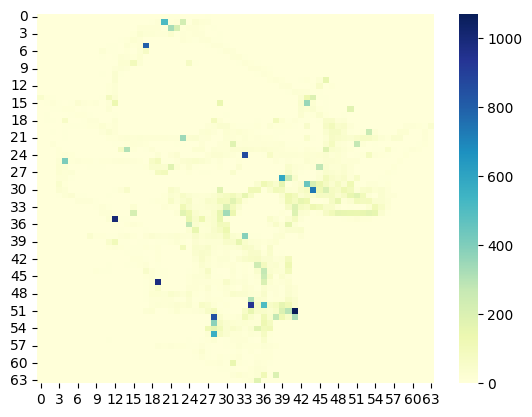

'\nAnswer: We can see from the plot that the area with bluest dotes is the place where enemies are situated most\nof the time\n'

In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#c. Now that we’ve gathered data on Team2 T side, let's examine their CT (counter-terrorist) Side. Using the same data set, tell our coaching
# staff where you suspect them to be waiting inside “BombsiteB” i. Hint: Try a heatmap

p1 = ProcessGameState(player_data_path)
p1.filter_by('side', 'CT', output_path) # filters list based on side (T or CT)
p2 = ProcessGameState(output_path) 
p2.filter_by('team', 'Team1', output_path) # filters list based on team (Team1 or Team2)
p3 = ProcessGameState(output_path) 

# Create a dictionary to store the player coordinates per round
round_coordinates = {}

for _, row in p3.data.iterrows():
    round_num = row['round_num']
    player_coordinates = (row['x'], row['y'])
    
    if round_num not in round_coordinates:
        round_coordinates[round_num] = []
    round_coordinates[round_num].append(player_coordinates)

# Now, create the heatmap with seaborn
all_coordinates = [coord for sublist in round_coordinates.values() for coord in sublist]
df = pd.DataFrame(all_coordinates, columns=['x', 'y'])

# Calculate the 2d histogram for the data
heatmap_data, xedges, yedges = np.histogram2d(df['x'], df['y'], bins=(64,64))

# Create the heatmap using seaborn
ax = sns.heatmap(heatmap_data, cmap="YlGnBu")

# Show the plot
plt.show()

'''
Answer: We can see from the plot that the area with bluest dotes is the place where enemies are situated most
of the time
'''

In [174]:
'''
Problem 3

3. (No Coding) Most of the time, our stakeholders (in this case, the CS:GO
coaching staff) aren’t tech-savvy enough to run code themselves. Propose a
solution to your product manager that:
a. could allow our coaching staff to request or acquire the output themselves
b. takes less than 1 weeks worth of work to implement


Answer: To empower the coaching staff to access and interpret strategic insights without
needing to run the code themselves, we suggest developing an intuitive, user-friendly web application.
This web dashboard, equipped with comprehensive data visualization tools,
will allow users to set custom filters and parameters based on specific needs, such as team, side, coordinates,
and more.
Users can request or view the output by interacting with the dashboard,
which will present the data through visual aids like heatmaps for player locations.
This application would take inputs like team names, game sides (Terrorist or Counter-Terrorist),
and specific map coordinates. Users could easily select these parameters and instantly visualize the data,
fostering strategic understanding.
The application would employ a combination of Python web frameworks such as Django or Flask for the backend,
and JavaScript libraries like D3.js or Plotly for data visualization on the frontend.
By incorporating such interactive visualization tools, we can offer to the non-technical 
demographic of our stakeholders, allowing them to use the strategic insights that data provides.
'''

'\nProblem 3\n\n3. (No Coding) Most of the time, our stakeholders (in this case, the CS:GO\ncoaching staff) aren’t tech-savvy enough to run code themselves. Propose a\nsolution to your product manager that:\na. could allow our coaching staff to request or acquire the output themselves\nb. takes less than 1 weeks worth of work to implement\n\n\nAnswer: To empower the coaching staff to access and interpret strategic insights without\nneeding to run the code themselves, we suggest developing an intuitive, user-friendly web application.\nThis web dashboard, equipped with comprehensive data visualization tools,\nwill allow users to set custom filters and parameters based on specific needs, such as team, side, coordinates,\nand more.\nUsers can request or view the output by interacting with the dashboard,\nwhich will present the data through visual aids like heatmaps for player locations.\nThis application would take inputs like team names, game sides (Terrorist or Counter-Terrorist),\nand s